In [1]:
import glob
import numpy as np
import os
import pickle
from utils import create_folders
from utils import split_stack
from create_movies import apply_create_movie
from create_movies import rgba_to_rgb
from matplotlib import pyplot as plt
from skimage import io
import pandas as pd

# Create color movies based on a variable
Create movies where the nucleus of each cell is colored based on the value of a variable. The variable is determined by the frame and particle id. The color is given by a colormap.

Start by defining the project path, all necessary folders are the created automatically. If you ran the pipeline first, everything should be already set up - just use the same `project_path`. 

In [2]:
project_path = "/home/lhinder/myscratch/test_env/" #Absolute path where this project is stored. End path with "/".
folders = ["stacks_raw","stacks_labeled","table_tracked","movies","tmp"]
create_folders(project_path,folders) #Create new folders if they don't already exist

Directory /home/lhinder/myscratch/test_env/stacks_raw already exists
Directory /home/lhinder/myscratch/test_env/stacks_labeled already exists
Directory /home/lhinder/myscratch/test_env/table_tracked already exists
Directory /home/lhinder/myscratch/test_env/movies already exists
Directory /home/lhinder/myscratch/test_env/tmp already exists


In [3]:
tmp_path = project_path+"tmp/" #where temporary files are stored
tiff_path = project_path + "stacks_labeled/"
tiff_file_paths = (glob.glob(tiff_path + "*.tif*"))
tiff_file_paths.sort()
tiff_file_names = [os.path.basename(name) for name in tiff_file_paths]
print("Found {nb_files} tiff file(s): {names}".format(nb_files=len(tiff_file_names),names = tiff_file_names))

Found 1 tiff file(s): ['series_1_Original.tif']


## Define parameters for coloring
A custom cmap is created, so colorings are comparable across frames/FOVs/experiments. The variable which the image is colored by is `variable_name`. 

#### RGB vs. RGBA

The output is an `RGBA` image, where the background is transparent. As some applications (e.g. `imagej`) can't natively handle transparency, there is an option `convert_to_rgb`. It will replace all transparent background pixels with a solid color. 

In [4]:
nb_cores = 10 # nb cores to use for multiprocessing
variable_name = 'ratio_c1' # what variable should be mapped
min_value = 0.75 #everything lower is mapped to lowest value of cmap
max_value = 2.50 #everything higher is mapped to highest value of cmap
cmap = plt.cm.Spectral #cmap to use
convert_to_rgb = True #convert RGBA to RGB

### Run code
Color all images listed in `tiff_file_paths`. Multiprocessing is implemented.

In [5]:
for tiff_path,tiff_name in zip(tiff_file_paths,tiff_file_names):
    tiff_file = io.imread(tiff_path)
    data_table = pd.read_pickle(project_path+"table_tracked/"+tiff_name+".pkl")
    chunks = split_stack(tiff_file,tmp_path,nb_cores)
    color_stack = apply_create_movie(data_table, chunks, variable_name, min_value, max_value, cmap)
    if convert_to_rgb:
        #optional arg 'col': RGB values to fill in (default 255, 255, 255)
        color_stack = rgba_to_rgb(color_stack)
    path = project_path+'movies/'+variable_name+'_'+tiff_name
    io.imsave(path,color_stack)

Splitting of dataset: 
Core 1/10: 5 frames [0-4].
Core 2/10: 5 frames [5-9].
Core 3/10: 5 frames [10-14].
Core 4/10: 5 frames [15-19].
Core 5/10: 5 frames [20-24].
Core 6/10: 5 frames [25-29].
Core 7/10: 5 frames [30-34].
Core 8/10: 5 frames [35-39].
Core 9/10: 5 frames [40-44].
Core 10/10: 5 frames [45-49].
Start workers ...
Wait for completion ...
Done. Processing time per frame: 0.13 seconds. Total time: 0.11 minutes.


### Preview the results
Select a frame to look at, and it will show the results of the last tiff file colored.

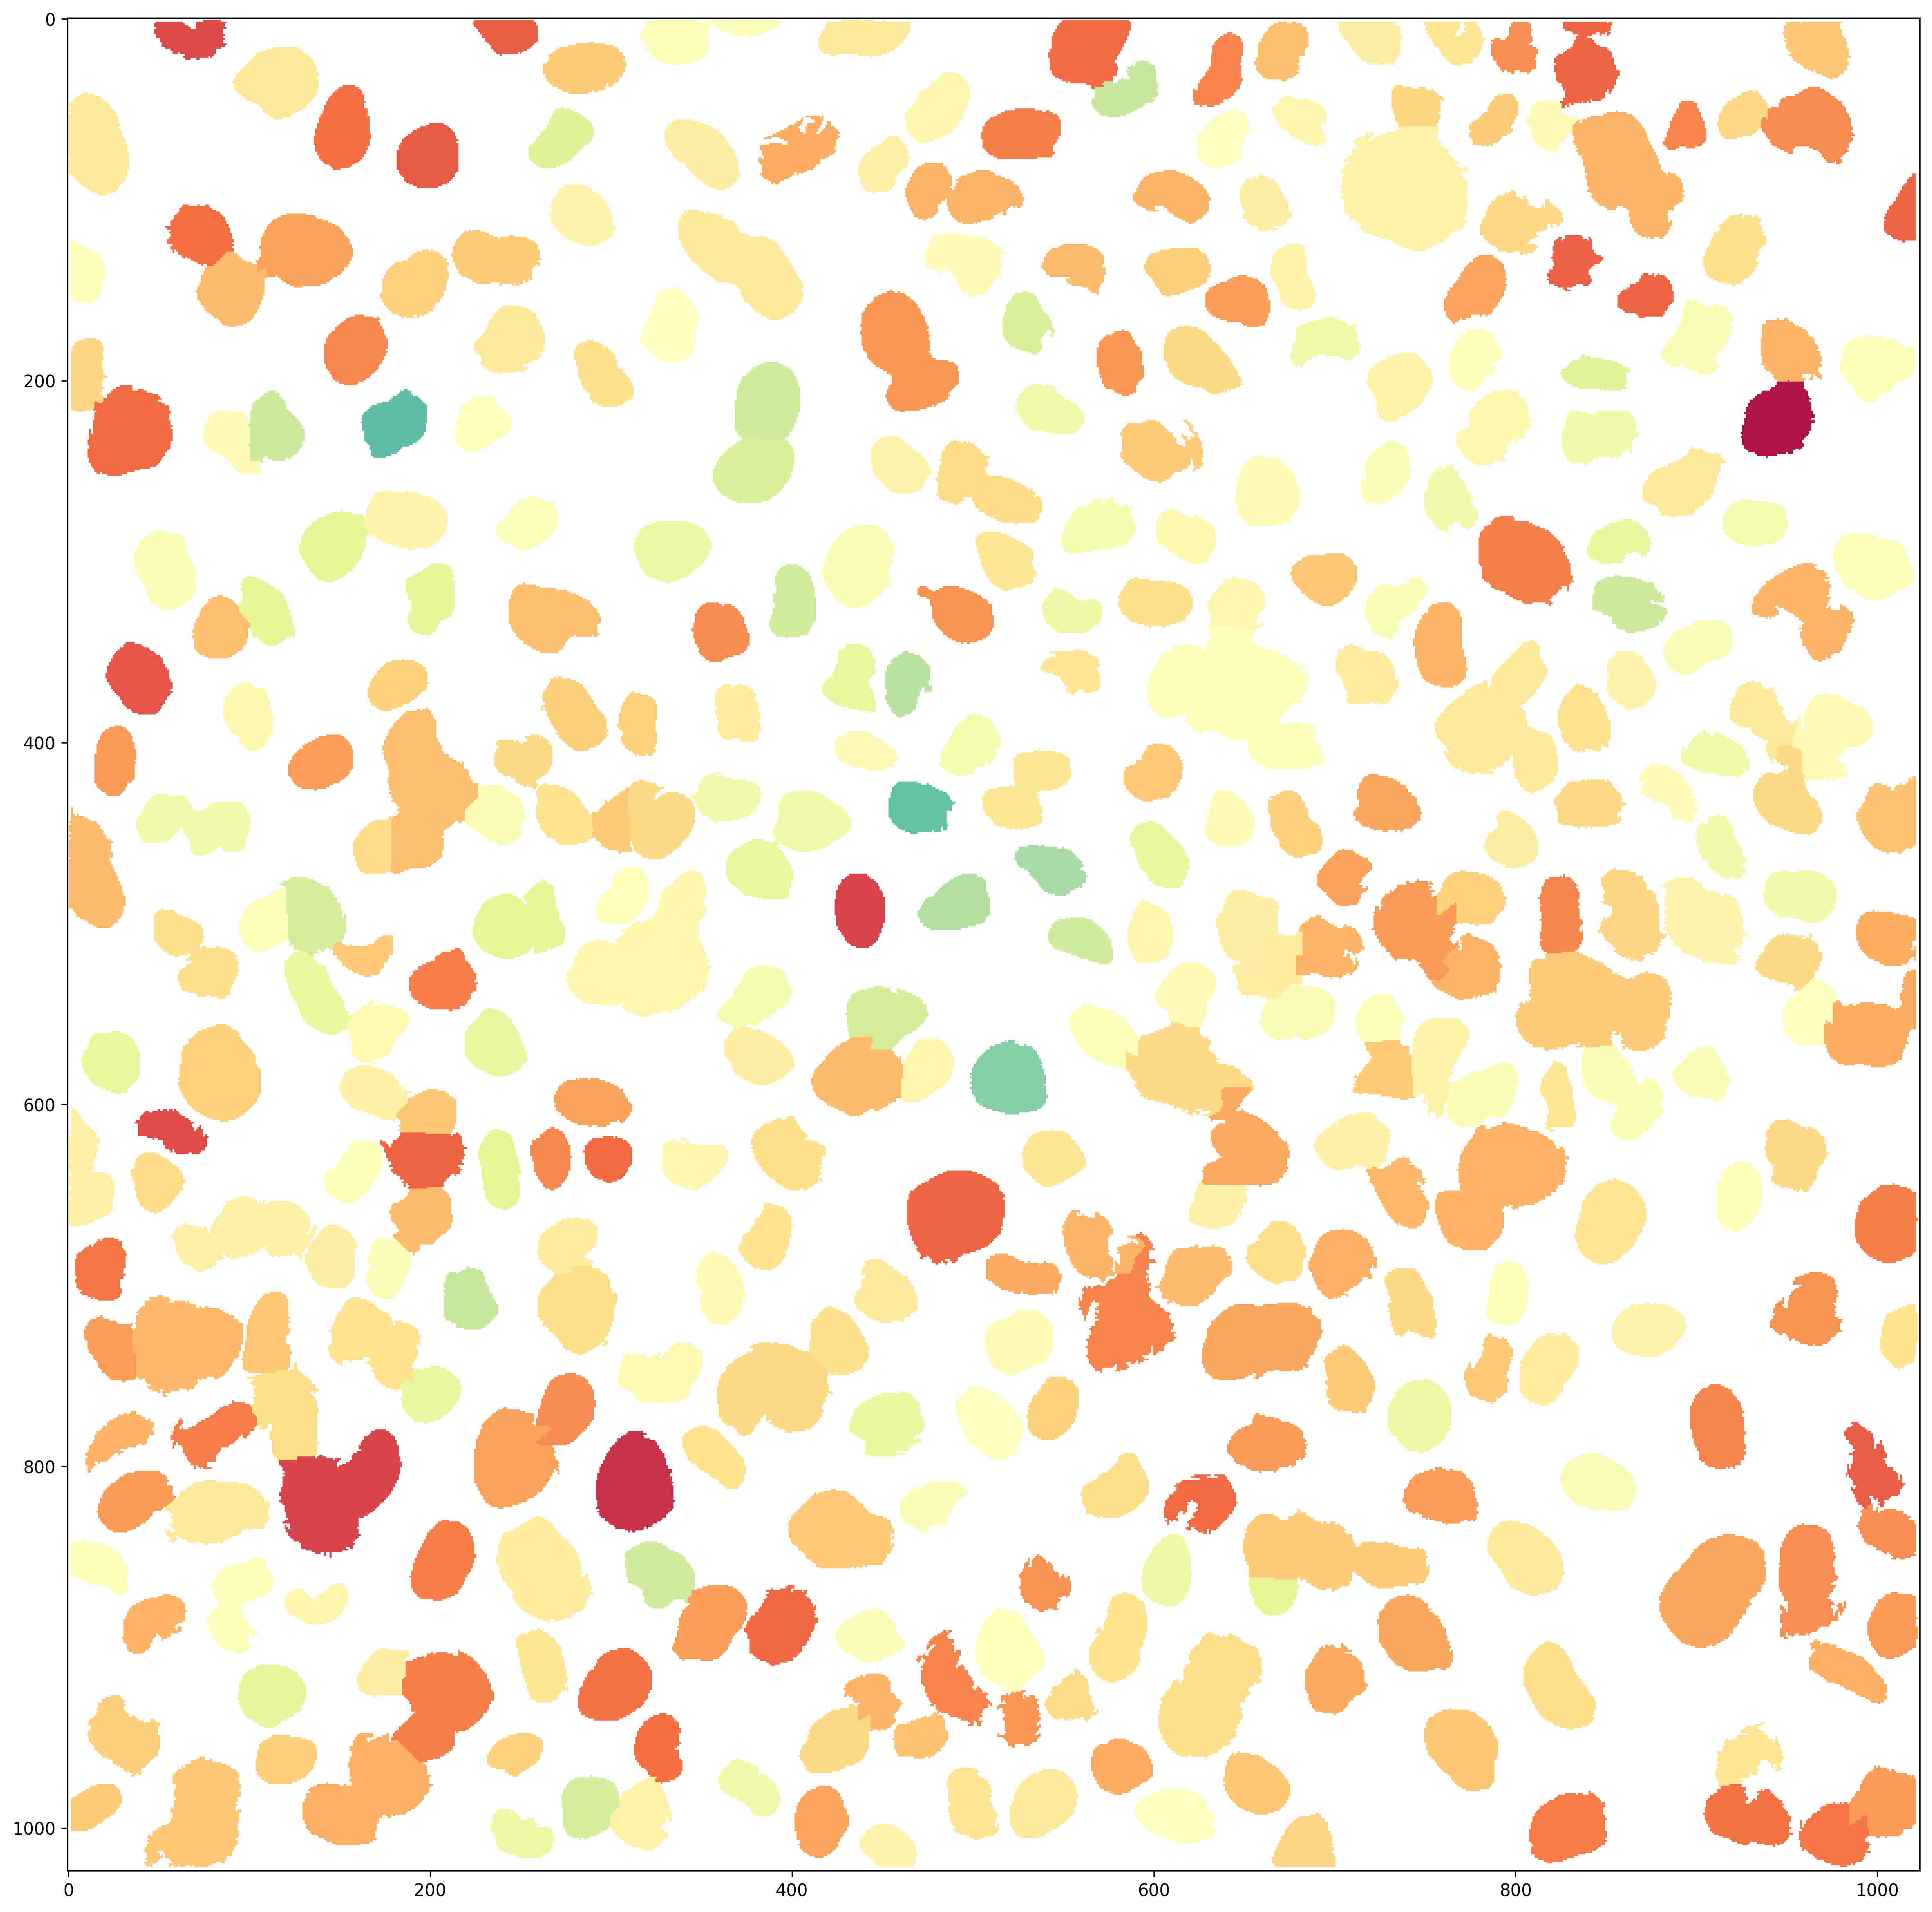

In [6]:
frame_nb = 20
plt.figure(figsize = (20,20),dpi = 300)
plt.imshow(color_stack[frame_nb,:,:])
plt.show()

### Confirm min/max values
The plot below will show the range of the variable chosen over time, to confirm the cmap/clipping of `min_value` and `max_value`.

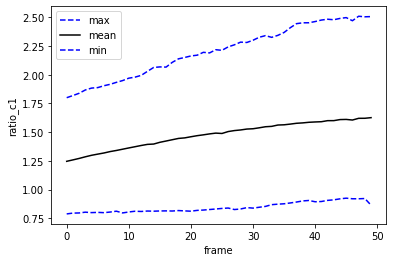

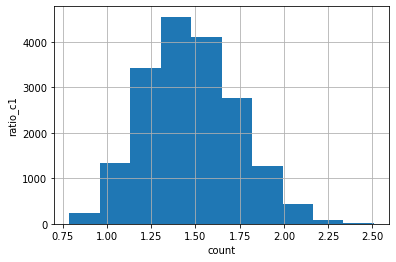

In [7]:
grp = data_table.groupby(['frame'])
grp[variable_name].max().plot(linestyle='--',c = 'b')
grp[variable_name].mean().plot(linestyle='-',c = 'k')
grp[variable_name].min().plot(linestyle='--',c = 'b')
plt.legend(['max','mean','min'])
plt.ylabel(variable_name)
plt.show()

data_table[variable_name].hist()
plt.ylabel(variable_name)
plt.xlabel('count')
plt.show()